# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter
from scipy.spatial import distance
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

pd.set_option('display.max_rows', None, 'display.max_columns', None)

print("Setup Complete")

Setup Complete


## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3499,1,22.0,65100.0,4,0
1731,0,24.0,43200.0,2,0
3211,0,31.0,40100.0,0,0
1732,0,30.0,42300.0,0,0
2942,0,46.0,36400.0,0,1
2840,1,22.0,36200.0,1,0
2262,1,36.0,44100.0,2,0
1149,0,22.0,47800.0,2,0
3846,0,37.0,40900.0,2,0
3827,0,45.0,30100.0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df.age = df.age.astype('int16')

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int16
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int16(1), int64(3)
memory usage: 166.1 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [9]:
display(df.describe())

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [10]:
print('NaNs:', df.isna().sum().sum())

NaNs: 0


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

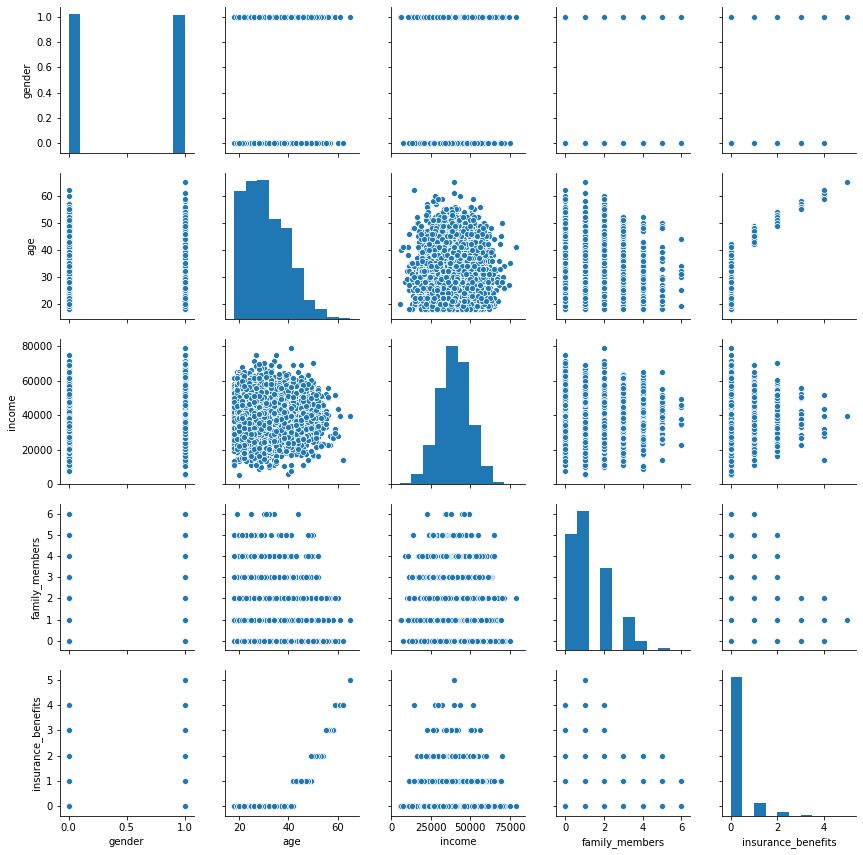

In [11]:
g = sns.pairplot(df)
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [12]:
features_plot= df.drop('insurance_benefits', axis=1)
target_plot= df['insurance_benefits']
features_plot = np.array(features_plot)
target_plot = np.array(target_plot)

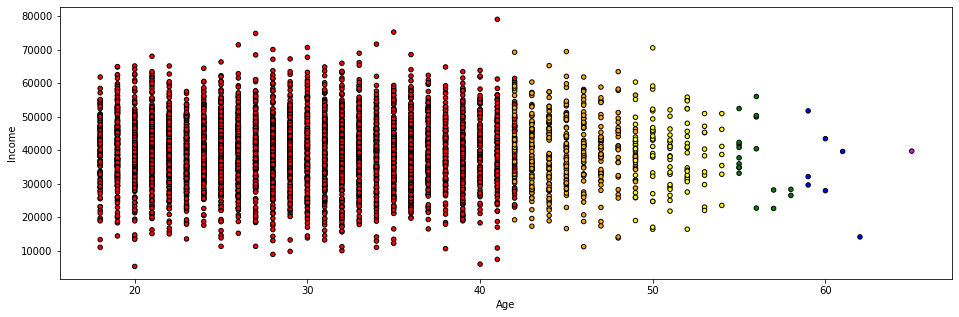

In [13]:
cmap = ListedColormap(['red', 'orange',  'yellow', 'green', 'blue','magenta'])
plt.figure(figsize=(16,5))
plt.scatter(features_plot[:, 1], features_plot[:, 2], c=target_plot, cmap=cmap, edgecolor='k',s=20)
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

Scatter plot of insurance_benefits classes distribution related to Income and Age columns

In [14]:
#Graph proof. Identifying the single point in magenta (scatterplot above) in the dataset.
print(df.query('insurance_benefits == 5'))

     gender  age   income  family_members  insurance_benefits
228       1   65  39700.0               1                   5


# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, radius=0.4, metric=metric)
    nbrs.fit(df[feature_names],df['insurance_benefits'])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [17]:
#Testing Euclidean distance on unscaled data
display(get_knn(df, 398, 5, distance.euclidean))

,gender,age,income,family_members,insurance_benefits,distance
398,0,30,37700.0,1,0,0.000000
2599,0,32,37700.0,2,0,2.236068
152,0,26,37700.0,3,0,4.472136
2039,1,34,37700.0,3,0,4.582576
2140,1,36,37700.0,1,0,6.082763


In [18]:
#Testing Manhattan distance on unscaled data
display(get_knn(df, 398, 5, distance.cityblock))

,gender,age,income,family_members,insurance_benefits,distance
398,0,30,37700.0,1,0,0.0
2599,0,32,37700.0,2,0,3.0
152,0,26,37700.0,3,0,6.0
2140,1,36,37700.0,1,0,7.0
2039,1,34,37700.0,3,0,7.0


Scaling the data.

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [20]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2239,0.0,0.476923,0.760759,0.166667,0
709,0.0,0.569231,0.505063,0.000000,0
2593,1.0,0.369231,0.470886,0.333333,0
1976,1.0,0.692308,0.408861,0.333333,1
206,1.0,0.553846,0.329114,0.166667,0


Now, let's get similar records for a given one for every combination

In [21]:
#Testing Euclidean distance on unscaled data
display(get_knn(df_scaled, 398, 5, distance.euclidean))

,gender,age,income,family_members,insurance_benefits,distance
398,0.0,0.461538,0.477215,0.166667,0,0.000000
4366,0.0,0.461538,0.482278,0.166667,0,0.005063
3242,0.0,0.461538,0.463291,0.166667,0,0.013924
2041,0.0,0.476923,0.478481,0.166667,0,0.015437
2238,0.0,0.476923,0.470886,0.166667,0,0.016636


In [22]:
#Testing Manhattan distance on unscaled data
display(get_knn(df_scaled, 398, 5, distance.cityblock))

,gender,age,income,family_members,insurance_benefits,distance
398,0.0,0.461538,0.477215,0.166667,0,0.000000
4366,0.0,0.461538,0.482278,0.166667,0,0.005063
3242,0.0,0.461538,0.463291,0.166667,0,0.013924
2041,0.0,0.476923,0.478481,0.166667,0,0.016650
2934,0.0,0.461538,0.458228,0.166667,0,0.018987


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The two Dataframes, scaled and unscaled returned different records within the datasets.\
- The unscaled one, for ID 398 returned as nearest points 2599, 152, 2140, 2039.
- The scaled data, for ID 398 returned as nearest points 4366, 3242, 2041, 2934.

The difference on the calculation is that in:
- On Scaled data, the higher values have an higher weight so the nearest points are choosen taking in consideration the column weight itself.
- On the Unscaled data, every column has the same weight, we calculations take in consideration the entirely DataFrame.

The results returned by the two Euclidean and Manhattan distance are different among them regarding the data scaling. They returned two different result on scaled and unscaled data. They look even different taking the values in columns.

For example, while **'family_members'** column:
- on **Unscaled** data had **all different values** [2,3,1,3] 
- the **Scaled** one, has **the same values** represented in the scaled numbers as [0.166667]. 

The contrary happend on **'income'** column:
- while on **Unscaled** data we have **all equal values** [37700.0] 
- on the **Scaled** dataset it returned **all different scaled values** [0.482278, 0.463291, 0.478481, 0.458228].

In my opinion, this happened because on Unscaled data, an high value like 377000 has a major weight compared to the other column values while calculating distances. 
- In the first example, turned out that all the values with the same income of the choosen data point were closer then the others because the income value is heaviest then the others.
- In the second example instead, the weights are equally distribuited for this reason the calculations of the closest point is done on every columns.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

For the data **Unscaled** the two distances returned the same data point. While the Euclidean distance is in floating numbers instead the Manhattan one, presents only integers. 

The point 2599 is just rounded to the next integer(2.236068 to 3), while the others change a little bit, the 152 from 4.472136 become 6.0 and the 2039 and 2140 from 4.582576 and 6.082763 become both 7.

For the **Scaled** data the points are the same as well, except for the last. While Euclidean returned as last nearest point the number 2238 the Manhattan returned the id 2934.

Here we can see that the distances are equals if we consider the number 4366 and 3242 while they differs on the two other data points but only really slightly.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [23]:
# calculate the target
df['insurance_benefits_received'] = df['insurance_benefits'] >= 1
df.loc[df['insurance_benefits_received'] == True, 'insurance_benefits_received'] = 1
df.loc[df['insurance_benefits_received'] == False, 'insurance_benefits_received'] = 0
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'] >= 1
df_scaled.loc[df['insurance_benefits_received'] == True, 'insurance_benefits_received'] = 1
df_scaled.loc[df['insurance_benefits_received'] == False, 'insurance_benefits_received'] = 0

In [24]:
# check for the class imbalance with value_counts()

print(df['insurance_benefits_received'].value_counts())
print()
print(df['insurance_benefits_received'].value_counts(normalize=True))

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64


In [25]:
#Assigning features and target Unscaled data
features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
target = df['insurance_benefits_received']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, random_state=0)
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3500, 4) (3500,)
(1500, 4) (1500,)


In [26]:
#Scaling data.
scaler = MaxAbsScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [27]:
def eval_classifier(target_test, predictions):
    
    f1_score = sklearn.metrics.f1_score(target_test, predictions)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(target_test, predictions)
    print('Confusion Matrix')
    print(cm)

In [28]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [29]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, features.shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[4436    0]
 [ 564    0]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[3957  479]
 [ 497   67]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[2280 2156]
 [ 265  299]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[   0 4436]
 [   0  564]]



In [30]:
#Confusion matrix of dummy rnd_model predictions. Scaled data
for P in [0, df_scaled['insurance_benefits_received'].sum() / len(df_scaled), 0.5, 1]:
    print(f'The probability: {P:.2f}')
    y_pred_rnd =  rnd_model_predict(P, df_scaled.shape[0])
    
    eval_classifier(df_scaled['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[4436    0]
 [ 564    0]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[3957  479]
 [ 497   67]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[2280 2156]
 [ 265  299]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[   0 4436]
 [   0  564]]



In [31]:
#K-NeighborsClassifier for k in range 10 + f1_score. Unscaled data
print('Unscaled data.')
unscaled_f1 = []
for k in range(1,11):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train, target_train)
    knc_pred = knc.predict(features_test)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    unscaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')

Unscaled data.
N_neighbors: 1, F1: 0.61
N_neighbors: 2, F1: 0.44
N_neighbors: 3, F1: 0.44
N_neighbors: 4, F1: 0.19
N_neighbors: 5, F1: 0.20
N_neighbors: 6, F1: 0.09
N_neighbors: 7, F1: 0.16
N_neighbors: 8, F1: 0.10
N_neighbors: 9, F1: 0.11
N_neighbors: 10, F1: 0.00


In [32]:
#K-NeighborsClassifier for k in range 10 + f1_score. Scaled data
print('Scaled data.')
scaled_f1 = []
for k in range(1,11):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train_scaled, target_train)
    knc_pred = knc.predict(features_test_scaled)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    scaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')

Scaled data.
N_neighbors: 1, F1: 0.95
N_neighbors: 2, F1: 0.92
N_neighbors: 3, F1: 0.94
N_neighbors: 4, F1: 0.89
N_neighbors: 5, F1: 0.91
N_neighbors: 6, F1: 0.89
N_neighbors: 7, F1: 0.91
N_neighbors: 8, F1: 0.89
N_neighbors: 9, F1: 0.91
N_neighbors: 10, F1: 0.90


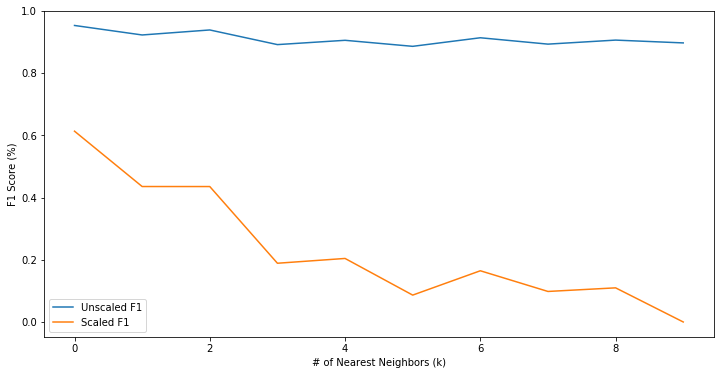

In [33]:
# Plot the results 
plt.figure(figsize=(12,6))
plt.plot(scaled_f1, label = "Unscaled F1")
plt.plot(unscaled_f1, label = 'Scaled F1')
plt.xlabel('# of Nearest Neighbors (k)')
plt.ylabel('F1 Score (%)')
plt.legend()
plt.show()

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [34]:
#Creating a class of LinearRegression.

class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights) + self.bias
        return y_pred

In [35]:
#def function to evaluate the classifier.

def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')  

In [36]:
#Testing the LR on the Unscaled data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [37]:
#Testing LR on Scaled data.
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train_scaled)
print(lr.weights)

y_test_pred_scaled = lr.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred_scaled)

[ 2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [46]:
#Creating a database taking in consideration only the 4 features columns.
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [47]:
#Generating a matrix X
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [48]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [49]:
print(np.linalg.inv(P))

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Can you guess the customers' ages or income after the transformation?

In [50]:
#Transforming the entire df in X1 (obfuscating data)
X1=X[:,:].dot(P)
print(X1)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [51]:
#Reversing from X1 the matrice X
X = X1.dot(np.linalg.inv(P))
print(X)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 ...
 [ 1.57996161e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [52]:
#Dropping unecessary columns for the matrice.
df_obfuscation = df_pn[:4]
df_obfuscation = df_pn
display(df_obfuscation)

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
5,1,43,41000.0,2
6,1,39,39700.0,2
7,1,25,38600.0,4
8,1,36,49700.0,1
9,1,32,51700.0,1


In [53]:
#Original data
raw = np.array(df_obfuscation)
print(raw)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


In [54]:
#Obfuscated data
obf = raw.dot(P)
print(obf)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


In [55]:
#Recovered
rec = obf.dot(np.linalg.inv(P))
print(rec)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 ...
 [ 1.57996161e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

From the results received I obtained really similar values to the one I had in the beginning. They change in infinitesimal floating points, this depends by the binary computation of computers. But basically 1.67952800e-12 mean a value near to the zero.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The predicted values of wP are going to be the same values of w multiplied for the matrice P, this way the data are going to be hide and not recognized but this is not going to change the quality of the Linear Regression itself that is going to remain as it is. Returning same results RMSE that mean that the algo can perform the task with the same root squared error. Being able to revert the process, will allow us to reobtain the real data from obfuscated predictions.

**Analytical proof**

$w = (X^T X)^{-1} X^T y$ \
$(X^T X)w = X^T y$ \
$(X^T)^{-1} (X^T X)w = y$

$w_P = [(XP)^T XP]^{-1} (XP)^T y$ \
$[(XP)^T XP]w_P = (XP)^T y$ \
$((XP)^T)^{-1}[(XP)^T XP]w_P = y$

$w$ and $wP$ are linked by $P^{-1}$ that can be write as: $w_p = P^{-1}w$.

Analitically the predictions formula can be written as:\
$y = Xw$

Instead the prediction of $w_p$ are:\
$y_p = X_pw_p = XPP^{-1}w$ = $Xw$

- Since the formula for $y$ and $y_p$ is the same, we can say that the original predictions are the same of the obfuscate dataset ones.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [56]:
class MyLinearRegression_obf:
    
    def __init__(self, data):
        self.weights = None
        self.data = data
        
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights) + self.bias
        return y_pred

In [57]:
#MyLinearRegression_obf on the normal dataset.
X = X
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression_obf(X)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.64272726e-02  3.57495491e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [58]:
#MyLinearRegression_obf on the obfuscated dataset.
X = X1
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression_obf(X1)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.05791721 -0.01546571  0.09871894 -0.02397536]
RMSE: 0.34
R2: 0.66


# Conclusions

> **Task 1**: I imported library to obtain the K neighbors for a given dataframe point. Scaling of our data changes totally the results. When the data are not scaled at all, the results we got are similar on the bigger values ('Income' in our case) cause the bigger values have an higher weights on the results. While scaling data we can return the right neighbors taking in consideration all the features.

> **Task 2:** I indentified the target of this task being 1 for any person that received at least 1 insurance benefit, and 0 for people who doesn't. The distribution of those values in our dataset is:  `88.72%` (0) and `11.28%` (1).
The results of our dummy model were in general really low values. 
Using KNeiborghsClassifier I plotted the f1 score for any values of K, on Unscaled data I obtained the higher value of `61%` with k==1, while scaling the data, our predictions resulted perfect obtaining a value of `95%`, this mean that the precision and the recall of the model itself are the best possible percentages.

> **Task 3**: I built LinearRegression model evaluating it on 2 different metrics, first **Root mean squared error (RMSE)** and **R2 score**, performing predictions on scaled and unscaled data, doesn't make any difference and the **RMSE** was calculated in `0.34` that is modest result, it mean that on a scale from 0 to 1 the mistakes made from the model predictions are `34%`. **R2** score in a range of 100, returned `66%`.

> **Task 4**: In this task was required to obfusc the data. I created a matrice P wich was invertible and multiplied it for our features matrice X. The dot product returned another matrice X1, that hides data letting them being not recognizable. It is possible to revert the process to re-obtain the starting values. I proved that our LR model performs the predictions in the same way on the obfuscated data having the same quality and the same metrics values.